# Regional Coincident Drought Analysis - By Resource

This notebook analyzes when different **regions** experience drought at the same time for a **single resource** type (PV or onshore wind). This is complementary to `new_coincident_drought_analysis.ipynb` which looks at when different resources experience drought in the same region.

**Research Question:** Which regions tend to experience drought together for the same resource? This helps understand spatial correlation patterns and portfolio diversification at the regional level.

**Approach:**
- Regional drought threshold: `drought_area_fraction > 0.2` (20% of region in drought)
- Calculate conditional overlap: P(region B in drought | region A in drought)
- Analyze separately for PV and onshore wind
- Multi-model and multi-GWL mean for representative patterns
- Visualize as correlation matrices (heatmaps)

## Setup and Configuration

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns

from renewable_data_load import *

In [2]:
# Set larger default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 16

In [3]:
# Analysis parameters
drought_threshold = 0.2  # Regional drought when >20% of area in drought
target_gwls = [0.8, 2.0]
simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]

# Utility regions to analyze
utility_regions = ["PG&E", "SCE", "SDG&E", "IID", "LDWP", "NCNC", "WECC_NW", "WECC_SW", "WECC_MTN"]

# Data paths
data_dir = Path("drought_masks")

## Load Regional Drought Data

Load pre-computed drought area fractions for each region.

In [4]:
def load_regional_drought_data(region, simulation, resource, module, gwl, data_dir):
    """
    Load drought area fraction time series for a specific region.
    
    Parameters
    ----------
    region : str
        Region name (e.g., 'PG&E', 'SCE')
    simulation : str
        Climate model name
    resource : str
        'pv' or 'windpower'
    module : str
        'utility' or 'onshore'
    gwl : float
        Global warming level
    data_dir : Path
        Directory containing NetCDF files
        
    Returns
    -------
    xr.DataArray
        Drought area fraction time series
    """
    filename = f"{region}_{simulation}_{resource}_{module}_gwl{gwl}_drought_area_fraction.nc"
    filepath = data_dir / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    
    return xr.open_dataarray(filepath)

In [5]:
# Load all data into a structured dictionary
print("Loading regional drought data...")
drought_data = {}

for gwl in target_gwls:
    drought_data[gwl] = {}
    print(f"\n  GWL {gwl}°C:")
    
    for sim in simulations:
        drought_data[gwl][sim] = {}
        print(f"    {sim}...", end=" ")
        
        for region in utility_regions:
            # Load PV and wind drought fractions
            pv_data = load_regional_drought_data(
                region, sim, "pv", "utility", gwl, data_dir
            )
            wind_data = load_regional_drought_data(
                region, sim, "windpower", "onshore", gwl, data_dir
            )
            
            drought_data[gwl][sim][region] = {
                'pv': pv_data,
                'wind': wind_data
            }
        
        print("✓")

print("\n✓ All data loaded!")

Loading regional drought data...

  GWL 0.8°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

  GWL 2.0°C:
    mpi-esm1-2-hr... ✓
    miroc6... ✓
    taiesm1... ✓
    ec-earth3... ✓

✓ All data loaded!


## Calculate Region-to-Region Drought Overlap

For each resource type, calculate conditional overlap between regions:
- P(region B in drought | region A in drought)
- Averaged with P(region A in drought | region B in drought) for symmetry
- Diagonal = 100% (region always overlaps with itself)

In [6]:
def calculate_regional_overlap_matrix(region_data_dict, threshold=0.2):
    """
    Calculate conditional overlap percentages between regions for a single resource.
    
    Returns a symmetric matrix where:
    - Diagonal = 100% (region always overlaps with itself)
    - Off-diagonal [i,j] = conditional probability that region j is in drought 
      given region i is in drought, averaged with [j,i] for symmetry
    
    Parameters
    ----------
    region_data_dict : dict
        Dictionary mapping region names to drought area fraction DataArrays
    threshold : float
        Drought threshold
        
    Returns
    -------
    np.ndarray
        N×N symmetric matrix of conditional overlap percentages
    list
        List of region names in matrix order
    """
    regions = list(region_data_dict.keys())
    n_regions = len(regions)
    
    # Create binary masks for each region
    masks = {}
    for region in regions:
        masks[region] = (region_data_dict[region] > threshold).values
    
    # Calculate conditional overlaps
    matrix = np.zeros((n_regions, n_regions))
    
    for i, region_i in enumerate(regions):
        for j, region_j in enumerate(regions):
            if i == j:
                # Diagonal: 100% (region always overlaps with itself)
                matrix[i, j] = 100.0
            else:
                # Off-diagonal: conditional probability
                both_in_drought = (masks[region_i] & masks[region_j]).sum()
                i_in_drought = masks[region_i].sum()
                j_in_drought = masks[region_j].sum()
                
                if i_in_drought > 0:
                    cond_prob_ij = (both_in_drought / i_in_drought) * 100
                else:
                    cond_prob_ij = 0
                
                if j_in_drought > 0:
                    cond_prob_ji = (both_in_drought / j_in_drought) * 100
                else:
                    cond_prob_ji = 0
                
                # Average for symmetric matrix
                matrix[i, j] = (cond_prob_ij + cond_prob_ji) / 2
    
    return matrix, regions

In [7]:
# Calculate overlap matrices for each resource, model, and GWL
print("Calculating regional overlap matrices...")

overlap_matrices = {
    'pv': {},
    'wind': {}
}

for resource_key, resource_name in [('pv', 'pv'), ('wind', 'wind')]:
    print(f"\n  Resource: {resource_key}")
    
    for gwl in target_gwls:
        overlap_matrices[resource_key][gwl] = {}
        print(f"    GWL {gwl}°C:")
        
        for sim in simulations:
            print(f"      {sim}...", end=" ")
            
            # Gather data for all regions for this resource
            region_data = {}
            for region in utility_regions:
                region_data[region] = drought_data[gwl][sim][region][resource_name]
            
            # Calculate overlap matrix
            matrix, regions = calculate_regional_overlap_matrix(
                region_data, threshold=drought_threshold
            )
            
            overlap_matrices[resource_key][gwl][sim] = {
                'matrix': matrix,
                'regions': regions
            }
            
            print("✓")

print("\n✓ Overlap matrices calculated!")

Calculating regional overlap matrices...

  Resource: pv
    GWL 0.8°C:
      mpi-esm1-2-hr... ✓
      miroc6... ✓
      taiesm1... ✓
      ec-earth3... ✓
    GWL 2.0°C:
      mpi-esm1-2-hr... ✓
      miroc6... ✓
      taiesm1... ✓
      ec-earth3... ✓

  Resource: wind
    GWL 0.8°C:
      mpi-esm1-2-hr... ✓
      miroc6... ✓
      taiesm1... ✓
      ec-earth3... ✓
    GWL 2.0°C:
      mpi-esm1-2-hr... ✓
      miroc6... ✓
      taiesm1... ✓
      ec-earth3... ✓

✓ Overlap matrices calculated!


## Calculate Multi-Model, Multi-GWL Mean

Average overlap matrices across all models and GWLs for representative spatial patterns.

In [8]:
# Calculate ensemble mean matrices
ensemble_matrices = {}

for resource_key in ['pv', 'wind']:
    print(f"Averaging {resource_key} matrices across models and GWLs...")
    
    all_matrices = []
    
    for gwl in target_gwls:
        for sim in simulations:
            all_matrices.append(overlap_matrices[resource_key][gwl][sim]['matrix'])
    
    ensemble_matrices[resource_key] = {
        'matrix': np.mean(all_matrices, axis=0),
        'regions': overlap_matrices[resource_key][target_gwls[0]][simulations[0]]['regions']
    }
    
    print(f"  ✓ {resource_key} ensemble mean calculated")

print("\n✓ All ensemble means calculated!")

Averaging pv matrices across models and GWLs...
  ✓ pv ensemble mean calculated
Averaging wind matrices across models and GWLs...
  ✓ wind ensemble mean calculated

✓ All ensemble means calculated!


## Figure 1: PV Drought - Regional Correlation Heatmap

Shows which regions tend to experience PV drought at the same time (multi-model, multi-GWL mean).

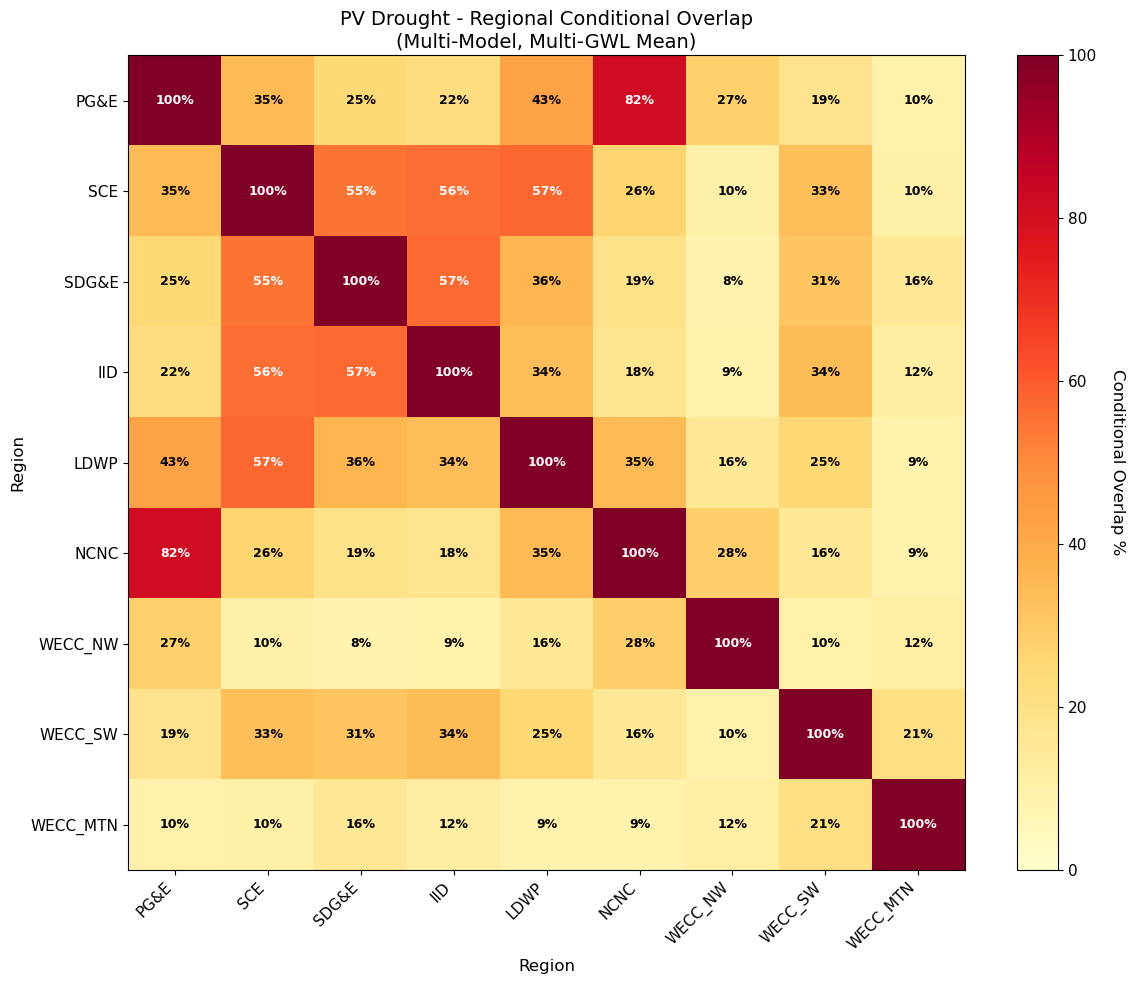

In [9]:
# Plot PV regional overlap heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

matrix = ensemble_matrices['pv']['matrix']
regions = ensemble_matrices['pv']['regions']

# Create heatmap
im = ax.imshow(matrix, cmap='YlOrRd', vmin=0, vmax=100, aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(regions)))
ax.set_yticks(np.arange(len(regions)))
ax.set_xticklabels(regions, rotation=45, ha='right')
ax.set_yticklabels(regions)

# Add percentage values as text
for i in range(len(regions)):
    for j in range(len(regions)):
        color = 'white' if matrix[i, j] > 50 else 'black'
        text = ax.text(j, i, f'{matrix[i, j]:.0f}%',
                      ha="center", va="center", color=color, 
                      fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('Region')
ax.set_ylabel('Region')
ax.set_title('PV Drought - Regional Conditional Overlap\n(Multi-Model, Multi-GWL Mean)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Conditional Overlap %', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('pv_regional_drought_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 2: Onshore Wind Drought - Regional Correlation Heatmap

Shows which regions tend to experience onshore wind drought at the same time (multi-model, multi-GWL mean).

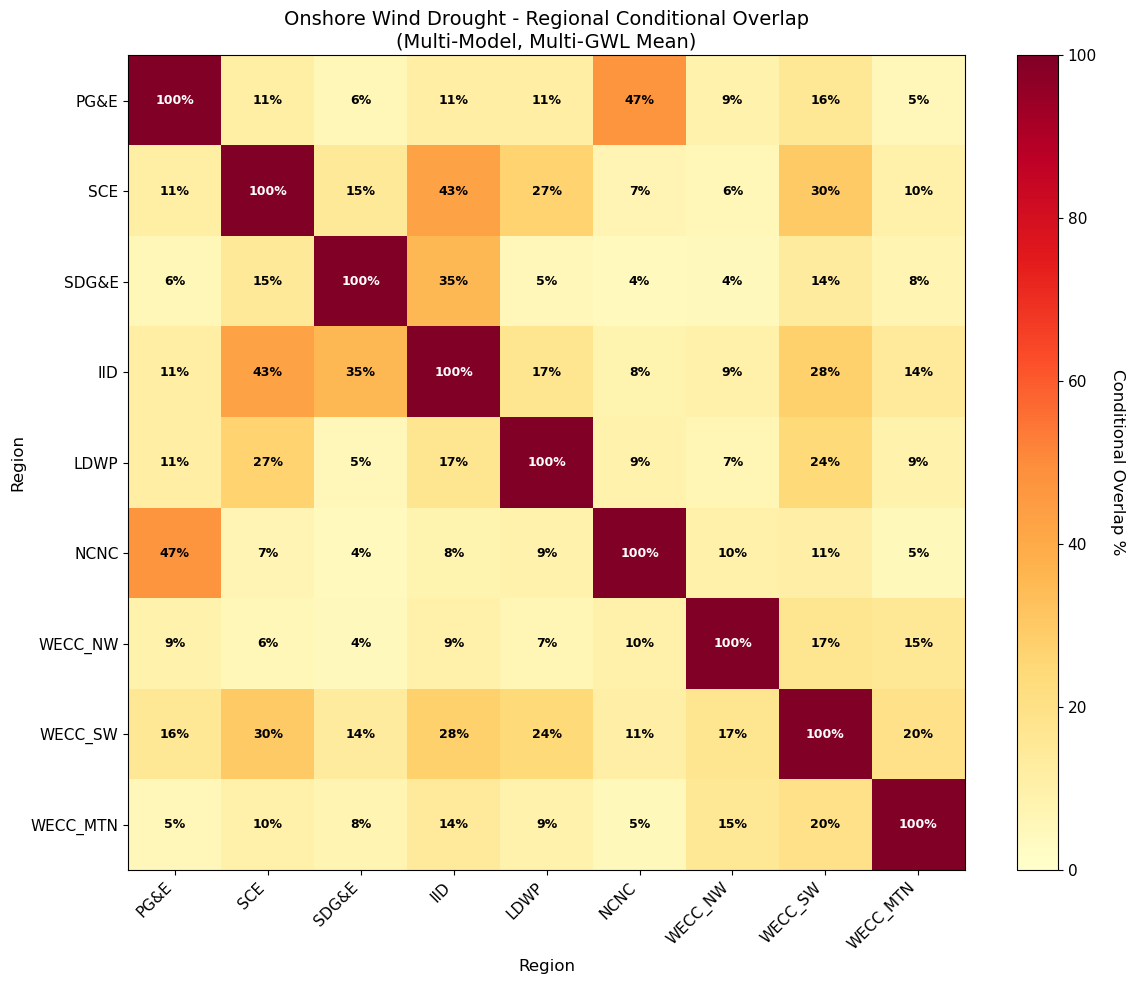

In [10]:
# Plot wind regional overlap heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

matrix = ensemble_matrices['wind']['matrix']
regions = ensemble_matrices['wind']['regions']

# Create heatmap
im = ax.imshow(matrix, cmap='YlOrRd', vmin=0, vmax=100, aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(regions)))
ax.set_yticks(np.arange(len(regions)))
ax.set_xticklabels(regions, rotation=45, ha='right')
ax.set_yticklabels(regions)

# Add percentage values as text
for i in range(len(regions)):
    for j in range(len(regions)):
        color = 'white' if matrix[i, j] > 50 else 'black'
        text = ax.text(j, i, f'{matrix[i, j]:.0f}%',
                      ha="center", va="center", color=color, 
                      fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('Region')
ax.set_ylabel('Region')
ax.set_title('Onshore Wind Drought - Regional Conditional Overlap\n(Multi-Model, Multi-GWL Mean)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Conditional Overlap %', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('wind_regional_drought_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 3: Side-by-Side Comparison

Compare PV and wind regional correlation patterns.

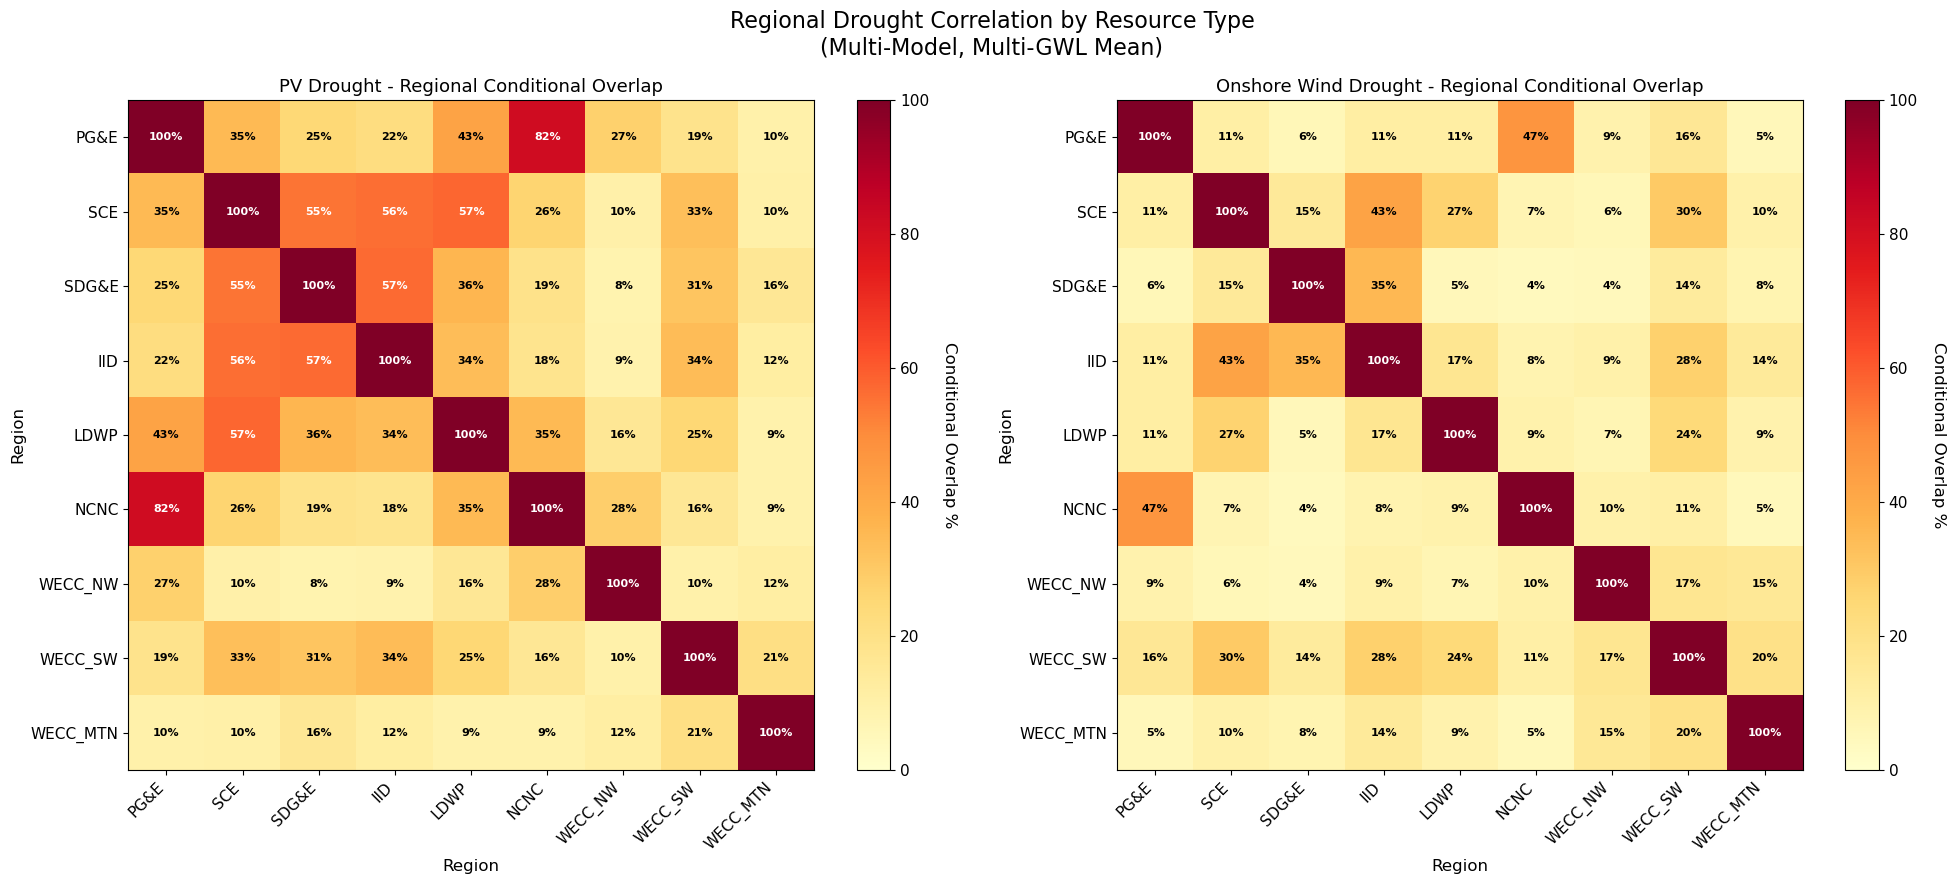

In [11]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

for idx, (resource_key, resource_name) in enumerate([('pv', 'PV'), ('wind', 'Onshore Wind')]):
    ax = axes[idx]
    
    matrix = ensemble_matrices[resource_key]['matrix']
    regions = ensemble_matrices[resource_key]['regions']
    
    # Create heatmap
    im = ax.imshow(matrix, cmap='YlOrRd', vmin=0, vmax=100, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(regions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_xticklabels(regions, rotation=45, ha='right')
    ax.set_yticklabels(regions)
    
    # Add percentage values as text
    for i in range(len(regions)):
        for j in range(len(regions)):
            color = 'white' if matrix[i, j] > 50 else 'black'
            text = ax.text(j, i, f'{matrix[i, j]:.0f}%',
                          ha="center", va="center", color=color, 
                          fontsize=8, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Region')
    ax.set_ylabel('Region')
    ax.set_title(f'{resource_name} Drought - Regional Conditional Overlap', fontsize=13)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Conditional Overlap %', rotation=270, labelpad=20)

fig.suptitle('Regional Drought Correlation by Resource Type\n(Multi-Model, Multi-GWL Mean)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('regional_drought_overlap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 4: GWL Comparison - PV Drought

Show how PV regional correlations change between GWL 0.8°C and 2.0°C.

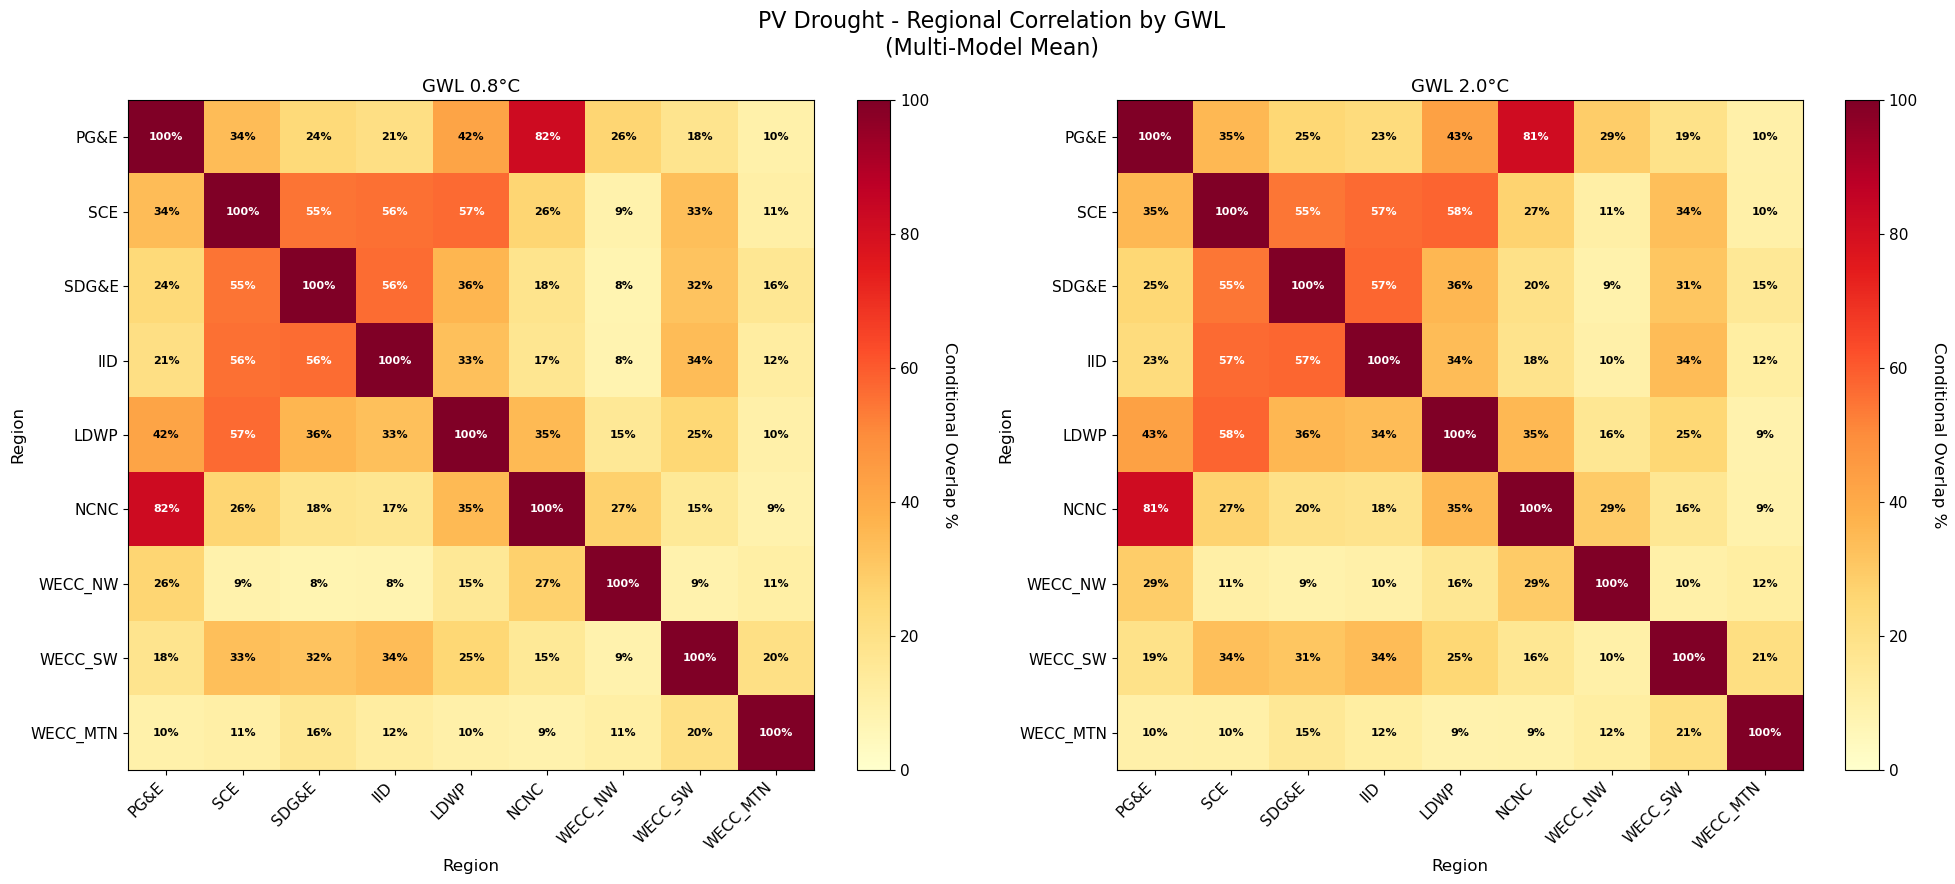

In [12]:
# Calculate GWL-specific ensemble means for PV
pv_gwl_matrices = {}

for gwl in target_gwls:
    matrices = []
    for sim in simulations:
        matrices.append(overlap_matrices['pv'][gwl][sim]['matrix'])
    pv_gwl_matrices[gwl] = np.mean(matrices, axis=0)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

for idx, gwl in enumerate(target_gwls):
    ax = axes[idx]
    
    matrix = pv_gwl_matrices[gwl]
    regions = ensemble_matrices['pv']['regions']
    
    # Create heatmap
    im = ax.imshow(matrix, cmap='YlOrRd', vmin=0, vmax=100, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(regions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_xticklabels(regions, rotation=45, ha='right')
    ax.set_yticklabels(regions)
    
    # Add percentage values as text
    for i in range(len(regions)):
        for j in range(len(regions)):
            color = 'white' if matrix[i, j] > 50 else 'black'
            text = ax.text(j, i, f'{matrix[i, j]:.0f}%',
                          ha="center", va="center", color=color, 
                          fontsize=8, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Region')
    ax.set_ylabel('Region')
    ax.set_title(f'GWL {gwl}°C', fontsize=13)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Conditional Overlap %', rotation=270, labelpad=20)

fig.suptitle('PV Drought - Regional Correlation by GWL\n(Multi-Model Mean)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('pv_regional_drought_overlap_by_gwl.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 5: GWL Comparison - Onshore Wind Drought

Show how wind regional correlations change between GWL 0.8°C and 2.0°C.

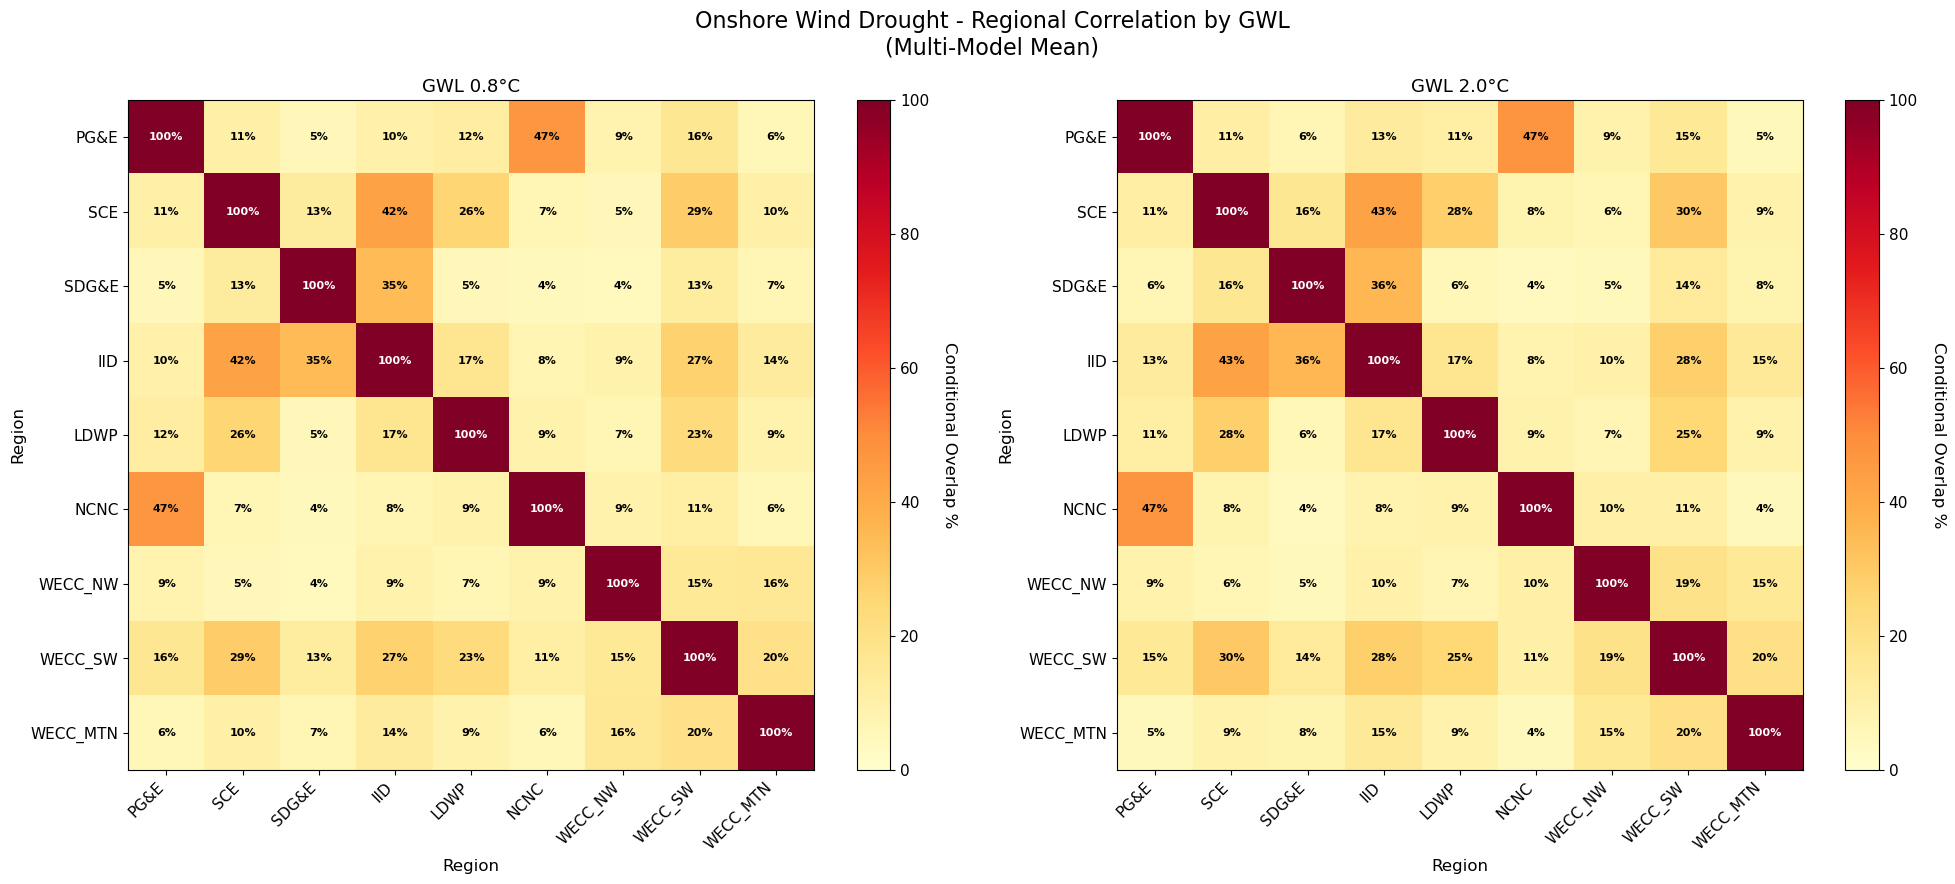

In [13]:
# Calculate GWL-specific ensemble means for wind
wind_gwl_matrices = {}

for gwl in target_gwls:
    matrices = []
    for sim in simulations:
        matrices.append(overlap_matrices['wind'][gwl][sim]['matrix'])
    wind_gwl_matrices[gwl] = np.mean(matrices, axis=0)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

for idx, gwl in enumerate(target_gwls):
    ax = axes[idx]
    
    matrix = wind_gwl_matrices[gwl]
    regions = ensemble_matrices['wind']['regions']
    
    # Create heatmap
    im = ax.imshow(matrix, cmap='YlOrRd', vmin=0, vmax=100, aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(regions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_xticklabels(regions, rotation=45, ha='right')
    ax.set_yticklabels(regions)
    
    # Add percentage values as text
    for i in range(len(regions)):
        for j in range(len(regions)):
            color = 'white' if matrix[i, j] > 50 else 'black'
            text = ax.text(j, i, f'{matrix[i, j]:.0f}%',
                          ha="center", va="center", color=color, 
                          fontsize=8, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Region')
    ax.set_ylabel('Region')
    ax.set_title(f'GWL {gwl}°C', fontsize=13)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Conditional Overlap %', rotation=270, labelpad=20)

fig.suptitle('Onshore Wind Drought - Regional Correlation by GWL\n(Multi-Model Mean)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('wind_regional_drought_overlap_by_gwl.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics

Calculate key metrics about regional correlations.

In [14]:
# Extract off-diagonal values (exclude diagonal which is always 100%)
def get_off_diagonal_values(matrix):
    """Get upper triangle excluding diagonal."""
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, k=1)]

print("Regional Correlation Summary Statistics")
print("="*60)

for resource_key, resource_name in [('pv', 'PV'), ('wind', 'Onshore Wind')]:
    print(f"\n{resource_name}:")
    print("-" * 40)
    
    matrix = ensemble_matrices[resource_key]['matrix']
    off_diag = get_off_diagonal_values(matrix)
    
    print(f"  Mean correlation: {off_diag.mean():.1f}%")
    print(f"  Median correlation: {np.median(off_diag):.1f}%")
    print(f"  Min correlation: {off_diag.min():.1f}%")
    print(f"  Max correlation: {off_diag.max():.1f}%")
    print(f"  Std deviation: {off_diag.std():.1f}%")
    
    # Find most correlated region pairs
    regions = ensemble_matrices[resource_key]['regions']
    n = len(regions)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((regions[i], regions[j], matrix[i, j]))
    
    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)
    
    print(f"\n  Top 5 most correlated pairs:")
    for i in range(min(5, len(pairs_sorted))):
        r1, r2, val = pairs_sorted[i]
        print(f"    {r1} ↔ {r2}: {val:.1f}%")
    
    print(f"\n  Top 5 least correlated pairs:")
    for i in range(min(5, len(pairs_sorted))):
        r1, r2, val = pairs_sorted[-(i+1)]
        print(f"    {r1} ↔ {r2}: {val:.1f}%")

Regional Correlation Summary Statistics

PV:
----------------------------------------
  Mean correlation: 26.8%
  Median correlation: 23.4%
  Min correlation: 8.4%
  Max correlation: 81.6%
  Std deviation: 17.2%

  Top 5 most correlated pairs:
    PG&E ↔ NCNC: 81.6%
    SCE ↔ LDWP: 57.4%
    SDG&E ↔ IID: 56.9%
    SCE ↔ IID: 56.2%
    SCE ↔ SDG&E: 54.7%

  Top 5 least correlated pairs:
    SDG&E ↔ WECC_NW: 8.4%
    IID ↔ WECC_NW: 8.8%
    NCNC ↔ WECC_MTN: 9.0%
    LDWP ↔ WECC_MTN: 9.3%
    WECC_NW ↔ WECC_SW: 9.6%

Onshore Wind:
----------------------------------------
  Mean correlation: 14.6%
  Median correlation: 10.9%
  Min correlation: 4.1%
  Max correlation: 47.1%
  Std deviation: 10.5%

  Top 5 most correlated pairs:
    PG&E ↔ NCNC: 47.1%
    SCE ↔ IID: 42.5%
    SDG&E ↔ IID: 35.3%
    SCE ↔ WECC_SW: 29.7%
    IID ↔ WECC_SW: 27.7%

  Top 5 least correlated pairs:
    SDG&E ↔ NCNC: 4.1%
    SDG&E ↔ WECC_NW: 4.4%
    NCNC ↔ WECC_MTN: 5.0%
    PG&E ↔ WECC_MTN: 5.4%
    SDG&E ↔ LDWP

## GWL Change Analysis

Calculate how regional correlations change from GWL 0.8 to 2.0.

In [15]:
print("Change in Regional Correlations (GWL 2.0 - GWL 0.8)")
print("="*60)

for resource_key, resource_name in [('pv', 'PV'), ('wind', 'Onshore Wind')]:
    print(f"\n{resource_name}:")
    print("-" * 40)
    
    # Calculate difference matrix
    matrix_08 = pv_gwl_matrices[0.8] if resource_key == 'pv' else wind_gwl_matrices[0.8]
    matrix_20 = pv_gwl_matrices[2.0] if resource_key == 'pv' else wind_gwl_matrices[2.0]
    diff_matrix = matrix_20 - matrix_08
    
    off_diag_diff = get_off_diagonal_values(diff_matrix)
    
    print(f"  Mean change: {off_diag_diff.mean():+.1f}%")
    print(f"  Median change: {np.median(off_diag_diff):+.1f}%")
    print(f"  Max increase: {off_diag_diff.max():+.1f}%")
    print(f"  Max decrease: {off_diag_diff.min():+.1f}%")
    
    # Find region pairs with largest changes
    regions = ensemble_matrices[resource_key]['regions']
    n = len(regions)
    changes = []
    for i in range(n):
        for j in range(i+1, n):
            changes.append((regions[i], regions[j], diff_matrix[i, j]))
    
    changes_sorted = sorted(changes, key=lambda x: abs(x[2]), reverse=True)
    
    print(f"\n  Top 5 largest changes:")
    for i in range(min(5, len(changes_sorted))):
        r1, r2, val = changes_sorted[i]
        print(f"    {r1} ↔ {r2}: {val:+.1f}%")

Change in Regional Correlations (GWL 2.0 - GWL 0.8)

PV:
----------------------------------------
  Mean change: +0.8%
  Median change: +1.0%
  Max increase: +3.0%
  Max decrease: -1.1%

  Top 5 largest changes:
    PG&E ↔ WECC_NW: +3.0%
    NCNC ↔ WECC_NW: +2.1%
    IID ↔ WECC_NW: +2.0%
    PG&E ↔ IID: +2.0%
    SDG&E ↔ WECC_NW: +1.8%

Onshore Wind:
----------------------------------------
  Mean change: +0.7%
  Median change: +0.7%
  Max increase: +4.3%
  Max decrease: -1.3%

  Top 5 largest changes:
    WECC_NW ↔ WECC_SW: +4.3%
    PG&E ↔ IID: +3.9%
    SCE ↔ SDG&E: +3.2%
    SCE ↔ LDWP: +2.2%
    SDG&E ↔ WECC_SW: +1.8%
